In [1]:
%matplotlib inline

from pymc3 import Normal, Model
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 22
import seaborn

/home/greg/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Hierarchical Non-Linear Regression Models in PyMC3: Part II

This is a follow up to a [previous post](www.ga7g08.github.io/2015/08/22/Hierarchical-Linear-Regression-Models-In-PyMC3-II/), extending to the case where we have nonlinear responces.

## First, some data

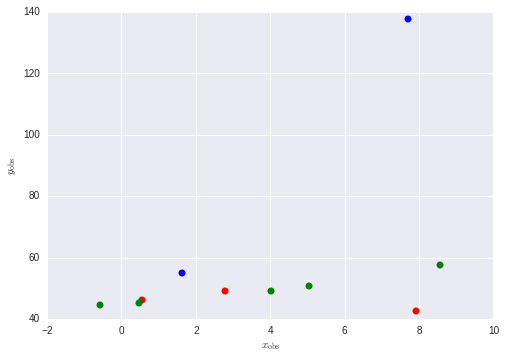

In [72]:
colors = ['r', 'g', 'b']
N_cars = 3
N_sightings = 10
idxs = np.array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

a_val = 45
mu_b_val = 0.1
sigma_b_val = 3
mu_c_val = 0.5
sigma_c_val = 0.5

b = np.random.normal(mu_b_val, sigma_b_val, N_cars)
c = np.random.normal(mu_c_val, sigma_c_val, N_cars)
xobs = np.random.uniform(0, 10, N_sightings) + np.random.normal(0, 1, N_sightings)
yobs = a_val + b[idxs]*xobs + c[idxs]*xobs**2

for i in range(N_cars):
    xobs_idv = xobs[idxs==i]
    yobs_idv = yobs[idxs==i]
    plt.plot(xobs_idv, yobs_idv, "o", color=colors[i])
    
plt.ylabel(r"$y_\mathrm{obs}$")
plt.xlabel(r"$x_\mathrm{obs}$")
plt.show()

## The clever bit:

In the following code we flatten the data, but create a set of indexes which maps the responces to the respondant. For example if our data data consisted of 2 repondants, with 3 responces from the first and 2 from the second, then the data above would be:
```
xobs_stacked = [[1.1, 2.2, 4.5], 
                [0.5, 0.4]]
yobs_stacked = [[10.2, 10.3, 10.8], 
                [12.5, 12.5]]
```

Then we flatten these to get
```
xobs = [1.1, 2.2, 4.5, 0.5, 0.4]
```
and create an index as follows
```
idxs = [0, 0, 0, 1, 1, ]
```
which says the first, second, and thrid entries below to the `0`th respondant, while the last two are from the second. The importance of this will become apparent in a moment. In this instance, we always have the same number of responces from each respondant, so we can use the following trick:

## The hierachical model


In [73]:
with pm.Model() as hierarchical_model:
    # hyperparameters
    mu_b = pm.Normal('mu_b', mu=0., sd=100)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)
    mu_c = pm.Normal('mu_c', mu=0., sd=100)
    sigma_c = pm.Uniform('sigma_c', lower=0, upper=100)

    # Common effects
    a = pm.Normal('a', mu=45, sd=100, testval=10)   
    eps = pm.Uniform('eps', lower=0, upper=10)
    
    # Group effects
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=N_cars)
    c = pm.Normal('c', mu=mu_b, sd=sigma_b, shape=N_cars)

    mu = a + b[idxs] * xobs + c[idxs] * xobs**2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=eps, observed=yobs)

Now we generate samples using the Metropolis algorithm. Note that in some of the linked examples they initiate the MCMC chains with a MLE. I found that this degraded the performance, but I don't have the time to figure out why at the moment. 

In [74]:
nsamples = 40000
nburn = 10000
with hierarchical_model:
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(nsamples, step, progressbar=True)

 [-----------------100%-----------------] 40000 of 40000 complete in 51.6 sec

Now let's use the handy `traceplot` to inspect the chains and the posteriors having discarded the first half of the samples. 

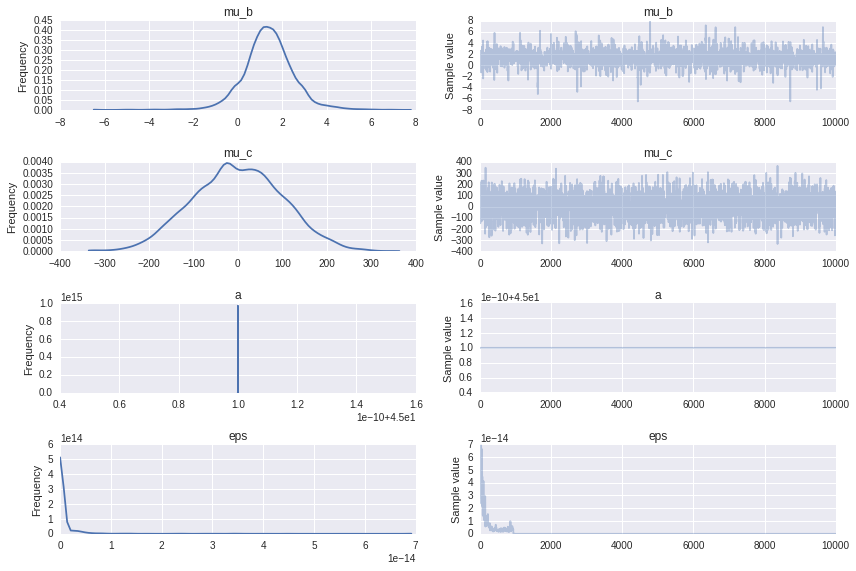

In [75]:
pm.traceplot(hierarchical_trace[30000:], 
             vars=['mu_b', 'mu_c', 'a', 'eps'],
             #lines={'mu_b': mu_b_val, 'sigma_b': sigma_b_val}
             )
plt.show()

The posterior distributions (in blue) can be compared with vertical (red) lines indicating the "true" values used to generate the data. This shows that we have not fully captured the features of the model, but compared to the diffuse prior we have learnt a great deal. Note that in generating the data $\epsilon$ was effectively zero: so the fact it's posterior is non-zero supports our understanding that we have not fully converged onto the idea solution.


## Posterior predictive check

Finally we will plot a few of the data points along with straight lines from several draws of the posterior. We color code 5 random data points, then draw 100 realisations of the parameters from the posteriors and plot the corresponding straight lines. This shows that the posterior is doing an excellent job at inferring the individual $b_i$ values.

In [40]:
s['b']

array([ 0.68617036, -0.0669098 , -0.28998365])

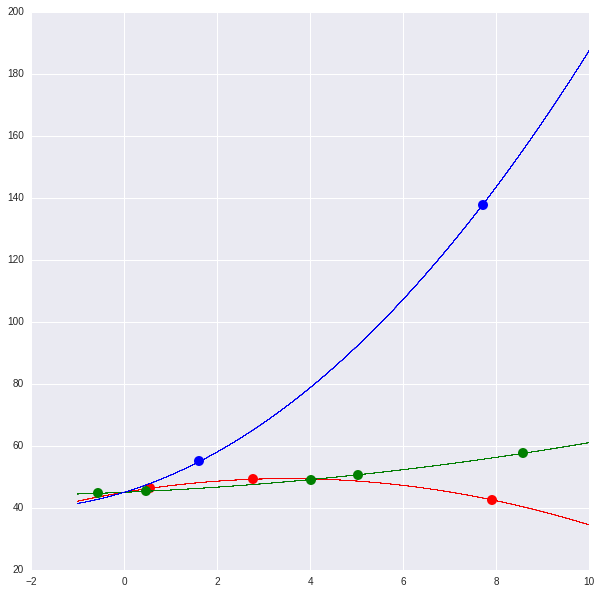

In [77]:
npp = 5
repeats = 100
fig, ax = plt.subplots(figsize=(10, 10))
xfit = np.linspace(-1, 10, 100)

for i  in range(N_cars):
    for j in range(repeats):
        s = hierarchical_trace[np.random.randint(nburn, nsamples)]
        yfit = s['a'] + s['b'][i] * xfit+  s['c'][i] * xfit**2
        ax.plot(xfit, yfit, "-", lw=0.1, color=colors[i])
    ax.plot(xobs[idxs == i], yobs[idxs == i], "o", color=colors[i], markersize=10)
    
plt.show()